<a href="https://colab.research.google.com/github/Sharman1661/STP_AIML_Sep25/blob/main/STP_Project_Module_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Appreciating, Interpreting and Visualizing Data

**Project: Understanding Customer Segments for Targeted Marketing**

Introduction: The Power of Customer Segmentation
---



Welcome to your Module 2 project!

In today's competitive landscape, understanding your customers is paramount for any business. Generic marketing strategies often fall flat, but by truly appreciating the diverse needs and behaviors within your customer base, businesses can create more effective, personalized experiences. This process is known as **customer segmentation**,

Customer segmentation involves dividing a broad customer base into subgroups of consumers who have common needs, interests, and priorities. By segmenting customers, companies can:

* **Tailor Marketing Messages:** Design specific campaigns that resonate with each group.
* **Optimize Product Development:** Create products and services that meet the unique demands of different segments.
* **Improve Customer Service:** Provide support that addresses common issues for particular groups.
* **Identify High-Value Customers:** Focus resources on segments that drive the most revenue.
* **Predict Churn:** Identify customers at risk of leaving and intervene proactively.

In this project, your task is to analyze a dataset of customer activity, use dimensionality reduction techniques to visualize customer behavior, and ultimately identify distinct customer segments. This will demonstrate how data visualization can provide actionable insights for business strategy, even without deep domain expertise at the outset.

We will first focus on a synthetic dataset containing various metrics related to customer purchasing habits and engagement. Your goal will be to:
* Process and prepare the raw customer data.
* Use **Principal Component Analysis (PCA)** to understand the main drivers of customer variation.
* Employ **t-Distributed Stochastic Neighbor Embedding (t-SNE)** to uncover hidden clusters of similar customers.
* (Optional Challenge) Explore **Uniform Manifold Approximation and Projection (UMAP)** for an alternative perspective.
* Interpret these visualizations to describe potential customer segments and suggest business implications.

Let's begin by setting up our environment and loading our customer data!


# 1. Data Acquisition and Initial Exploration

For this tutorial, we will first work with a synthetic dataset named ecommerce_customer_data.csv. This file contains anonymized data representing various aspects of customer engagement and purchasing behavior over a period.

First, let's ensure we have our necessary libraries installed and then load the dataset.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP # Uncomment if you plan to use UMAP

# For better progress bars with some operations
from tqdm.autonotebook import tqdm

In [ ]:
# Load the dataset
try:
    data = pd.read_csv("ecommerce_customer_data.csv")
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("ecommerce_customer_data.csv not found. Creating a synthetic dataset...")
    # Create a synthetic dataset if the file doesn't exist
    np.random.seed(42)
    num_customers = 500

    data = pd.DataFrame({
        'CustomerID': np.arange(1, num_customers + 1),
        'Age': np.random.randint(18, 70, num_customers),
        'Gender': np.random.choice(['Male', 'Female'], num_customers),
        'Average_Order_Value': np.random.normal(50, 20, num_customers).round(2).clip(min=5),
        'Number_of_Purchases': np.random.randint(1, 30, num_customers),
        'Days_Since_Last_Purchase': np.random.randint(1, 180, num_customers),
        'Product_Category_Preference': np.random.choice(['Electronics', 'Apparel', 'Books', 'Home Goods', 'Beauty'], num_customers),
        'Customer_Lifetime_Value': np.random.normal(200, 100, num_customers).round(2).clip(min=10)
    })
    # Introduce some correlations to create 'segments'
    data.loc[data['Age'] < 25, 'Product_Category_Preference'] = np.random.choice(['Electronics', 'Apparel'], sum(data['Age'] < 25))
    data.loc[data['Age'] < 25, 'Average_Order_Value'] = np.random.normal(30, 10, sum(data['Age'] < 25)).round(2).clip(min=5)
    data.loc[data['Product_Category_Preference'] == 'Books', 'Number_of_Purchases'] = np.random.randint(10, 40, sum(data['Product_Category_Preference'] == 'Books'))
    data.loc[data['Product_Category_Preference'] == 'Books', 'Customer_Lifetime_Value'] = np.random.normal(300, 150, sum(data['Product_Category_Preference'] == 'Books')).round(2).clip(min=10)
    data.loc[data['Number_of_Purchases'] > 20, 'Average_Order_Value'] = np.random.normal(70, 25, sum(data['Number_of_Purchases'] > 20)).round(2).clip(min=5)

    data.to_csv("ecommerce_customer_data.csv", index=False)
    print("Synthetic dataset created and saved as ecommerce_customer_data.csv")


ecommerce_customer_data.csv not found. Creating a synthetic dataset...
Synthetic dataset created and saved as ecommerce_customer_data.csv


In [ ]:
print("\nDataset Head:")
print(data.head())
print("\nDataset Info:")
data.info()
print("\nDataset Description:")
print(data.describe())


Dataset Head:
   CustomerID  Age  Gender  Average_Order_Value  Number_of_Purchases  \
0           1   56  Female                15.93                    2   
1           2   69    Male                48.89                   15   
2           3   46    Male                57.68                   14   
3           4   32  Female                49.35                   20   
4           5   60    Male                64.78                   22   

   Days_Since_Last_Purchase Product_Category_Preference  \
0                        49                  Home Goods   
1                        35                     Apparel   
2                       172                 Electronics   
3                       102                     Apparel   
4                        11                  Home Goods   

   Customer_Lifetime_Value  
0                   193.68  
1                    47.85  
2                   218.16  
3                   370.92  
4                    87.96  

Dataset Info:
<class '

From the initial look, we have numerical features like Age, Average_Order_Value, Number_of_Purchases, Days_Since_Last_Purchase, and Customer_Lifetime_Value. We also have categorical features: Gender and Product_Category_Preference. CustomerID is just an identifier.

# 2. Feature Engineering and Preprocessing

Before we can apply dimensionality reduction techniques, we need to convert all our features into a numerical format and scale them appropriately. This is crucial because algorithms like PCA and t-SNE are sensitive to the magnitude of the features.

Here's our plan:
* **Drop CustomerID:** It's an identifier and doesn't contain behavioral information.
* **One-Hot Encode Categorical Features:** Convert Gender and Product_Category_Preference into numerical representations.
* **Standardize Numerical Features:** Scale all numerical features to have a mean of 0 and a standard deviation of 1.

In [ ]:
# 1. Drop CustomerID
features_df = data.drop('CustomerID', axis=1)

# 2. One-Hot Encode Categorical Features
features_df = pd.get_dummies(features_df, columns=['Gender', 'Product_Category_Preference'], drop_first=True)

# Separate numerical columns for scaling
numerical_cols = ['Age', 'Average_Order_Value', 'Number_of_Purchases', 'Days_Since_Last_Purchase', 'Customer_Lifetime_Value']
categorical_cols_encoded = [col for col in features_df.columns if col not in numerical_cols]

# 3. Standardize Numerical Features
scaler = StandardScaler()
features_df[numerical_cols] = scaler.fit_transform(features_df[numerical_cols])

print("Processed Features Head:")
print(features_df.head())
print("\nProcessed Features Info:")
features_df.info()

# Store original labels for visualization
customer_labels = data['Product_Category_Preference'] # We'll use this as a 'ground truth' for coloring

Processed Features Head:
        Age  Average_Order_Value  Number_of_Purchases  \
0  0.784233            -1.645682            -1.568283   
1  1.649686            -0.282341            -0.195190   
2  0.118500             0.081244            -0.300813   
3 -0.813526            -0.263314             0.332922   
4  1.050527             0.374924             0.544167   

   Days_Since_Last_Purchase  Customer_Lifetime_Value  Gender_Male  \
0                 -0.796795                -0.242712        False   
1                 -1.059552                -1.442399         True   
2                  1.511721                -0.041324         True   
3                  0.197932                 1.215374        False   
4                 -1.509994                -1.112430         True   

   Product_Category_Preference_Beauty  Product_Category_Preference_Books  \
0                               False                              False   
1                               False                            

Now our data features_df is ready for dimensionality reduction!

# 3. Dimensionality Reduction: Principal Component Analysis (PCA)

PCA is a linear dimensionality reduction technique that transforms the data into a new coordinate system where the greatest variance by any projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on. It helps us capture the most important information (variance) in fewer dimensions.

First, let's look at how much variance each principal component explains.

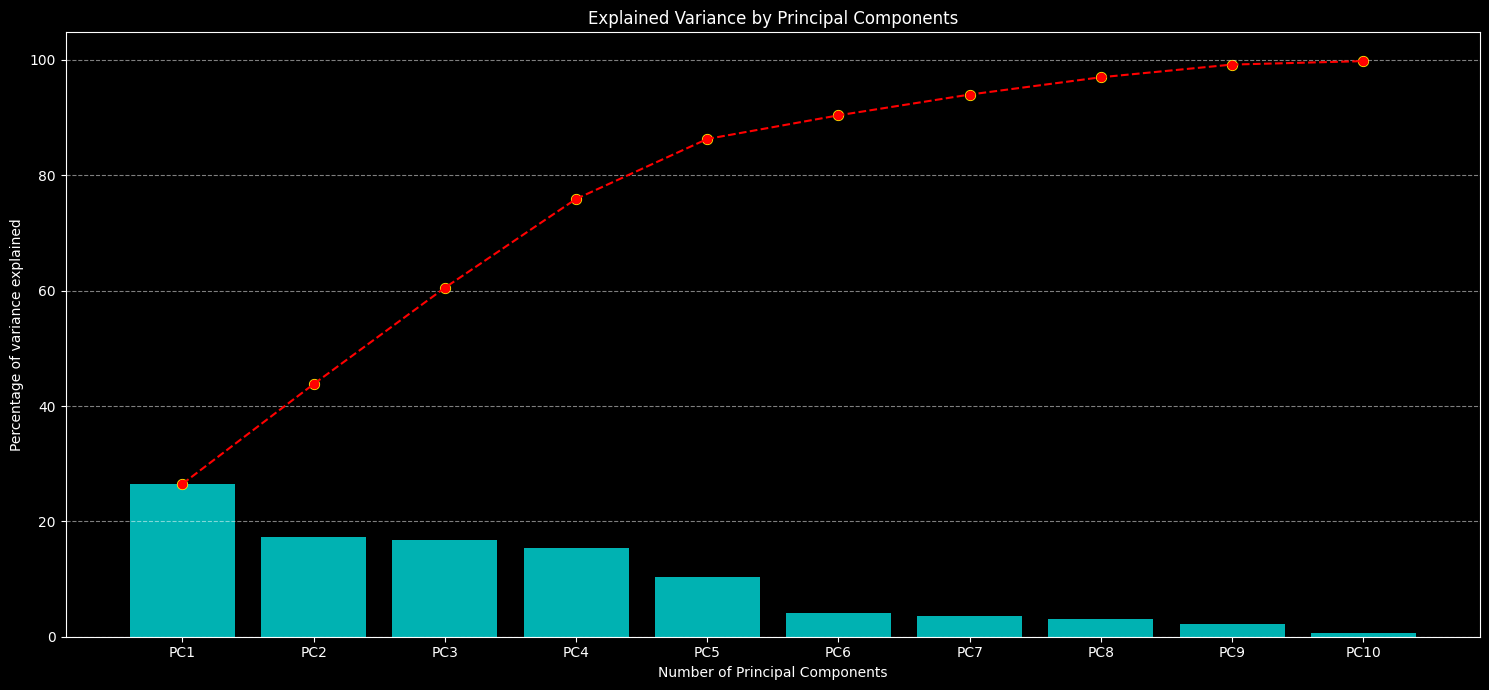

In [ ]:
# Create a PCA object
pca = PCA()
# Do the math - fit PCA to our processed features
pca.fit(features_df)
# Get PCA coordinates for the matrix
pca_data = pca.transform(features_df)

# Calculate explained variance ratio
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels_all = ['PC' + str(x) for x in range(1, len(per_var) + 1)]

# Limit to the first 10 components for visualization purposes
per_var_display = per_var[:10]
labels_display = labels_all[:10]

# Create an explained variance plot
with plt.style.context('dark_background'):
    plt.figure(figsize=(15, 7))
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Percentage of variance explained")
    plt.bar(range(1, len(per_var_display) + 1), per_var_display, tick_label=labels_display, color="cyan", alpha=0.7)
    plt.plot(range(1, len(per_var_display) + 1), np.cumsum(per_var_display), color="red", marker='o', linestyle='--')
    plt.scatter(range(1, len(per_var_display) + 1), np.cumsum(per_var_display), color="yellow", s=50)
    plt.title("Explained Variance by Principal Components")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


**Observation:** The first few principal components capture a significant portion of the variance in our customer dataset. The cumulative variance curve shows how many components are needed to explain a certain amount of the total variation.

Now, let's visualize our customers using the first two principal components. We'll color the points by their Product_Category_Preference (which we saved earlier) to see if PCA naturally separates customers based on this known characteristic.

In [ ]:
# Create a DataFrame for the first two principal components
pca_df = pd.DataFrame(data=pca_data[:, 0:2], columns=['PC1', 'PC2'])
pca_df['Product_Category_Preference'] = customer_labels.values

# Plot using Plotly Express
fig = px.scatter(pca_df, x='PC1', y='PC2', color='Product_Category_Preference',
                 title="Customer Segmentation via PCA (Colored by Product Preference)",
                 labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
                 hover_data=['Product_Category_Preference'], # Add hover info
                 height=600, width=900,
                 color_discrete_sequence=px.colors.qualitative.Bold) # Use a nice color sequence
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)', # Transparent background
    paper_bgcolor='rgba(0,0,0,0)',
    font_color='white'
)
fig.show(renderer="colab")

Your turn to interpret!

**Observations from PCA Plot:**
* Do you see any clear separation based on Product_Category_Preference?
* Are there any dense clusters, even if they contain mixed preferences?
* What does the spread of points suggest about customer behavior?

PCA provides a good overall view, but it's a linear method. Sometimes, complex, non-linear relationships between data points are better captured by other techniques.

**Answers**

1. No, there isn't a strict separation based on Product_Category_Preference. There are slight trends- books (colored in pink) seem to have high values of PC1 but low values of PC2, hence are mainly towards the right. Yellow seems to be towards the middle throughout. 'Apparel' (purple) and 'Home Goods' (blue) appear more centrally located and mixed with other groups. These are not strict trends, just very rough ones. Several outliers are present.

2. Yes, the data seems to be clustered around the lines 0 and 0 of the PC1 and PC2, between -1 and 1 of each. This implies that customers who exhibit similar overall purchasing and engagement patterns (as captured by PC1 and PC2) might still have varied product category preferences.

3. The overall spread of points across the PCA plot suggests a diverse range of customer behaviors. The fact that points are not concentrated in a single tight group indicates that there isn't a single customer type. Instead, customers vary significantly along the dimensions represented by PC1 and PC2. These principal components capture the most variance in the original features. A wide spread means that customers differ substantially in each of the values as transformed into numerical values.

# 4. Dimensionality Reduction: t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE is a non-linear dimensionality reduction algorithm particularly well-suited for visualizing high-dimensional datasets. It aims to place data points in a low-dimensional space such that points that are close together in the high-dimensional space remain close together in the low-dimensional map, and points that are far apart remain far apart. t-SNE is excellent at revealing local structures and clusters.

A key parameter in t-SNE is perplexity. Perplexity relates to the number of nearest neighbors that are considered. It can be thought of as a continuous measure of the number of effective nearest neighbors. A good perplexity value often lies between 5 and 50. Different perplexity values can reveal different aspects of the data structure. n_iter defines the number of iterations for the optimization.

Let's apply t-SNE to our features_df and visualize the results.

In [ ]:
# Set parameters for t-SNE
random_state = 42 # for reproducibility
n_components = 2  # We want 2D for visualization
perplexity = 30   # A common starting point; experiment with values like 5, 15, 50
n_iter = 1000     # Number of iterations for optimization

print(f"Applying t-SNE with perplexity={perplexity}, n_iter={n_iter}...")

# Create a t-SNE model object
model_tsne = TSNE(n_components=n_components, random_state=random_state,
                  perplexity=perplexity, n_iter=n_iter, n_jobs=-1, verbose=1) # n_jobs=-1 uses all available cores

# Fit and transform the data
# Use tqdm for a progress bar if running in a loop or with many iterations
tsne_data = model_tsne.fit_transform(features_df)

print("t-SNE completed.")

# Create a DataFrame for t-SNE results
tsne_df = pd.DataFrame(data=tsne_data, columns=['TSNE1', 'TSNE2'])
tsne_df['Product_Category_Preference'] = customer_labels.values

# Plot using Plotly Express
fig = px.scatter(tsne_df, x='TSNE1', y='TSNE2', color='Product_Category_Preference',
                 title=f"Customer Segmentation via t-SNE (Perplexity={perplexity})",
                 labels={'TSNE1': 't-SNE Component 1', 'TSNE2': 't-SNE Component 2'},
                 hover_data=['Product_Category_Preference'],
                 height=600, width=900,
                 color_discrete_sequence=px.colors.qualitative.Bold)
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font_color='white'
)
fig.show(renderer="colab")

Applying t-SNE with perplexity=30, n_iter=1000...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.003s...
[t-SNE] Computed neighbors for 500 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.945900


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] KL divergence after 100 iterations with early exaggeration: 62.500820
[t-SNE] KL divergence after 1000 iterations: 1.131116
t-SNE completed.


**Observations from t-SNE Plot:**
* How does this plot compare to the PCA plot? Is the separation of clusters more distinct?
* Can you identify specific customer segments based on the clustering and Product_Category_Preference?
* Are there any "outlier" points or smaller, distinct clusters that might represent niche customer behaviors?

**Experimentation Challenge:**
Try changing the perplexity parameter (e.g., to 5, 15, 50, or 100) and re-run the t-SNE code. How does this affect the clusters and overall structure of the plot? Which perplexity value seems to reveal the most interpretable customer segments?

1. Yes, the separation of clusters is more distinct. The t-SNE plot generally shows a much clearer separation of clusters compared to the PCA plot. While PCA showed some subtle trends for Books and Apparel, the t-SNE plot reveals more distinct, localized groupings of customers. The overall structure is less linear and more organized.

2. Identified Customer Segments:

    Books (Pink): There is a very distinct and tight cluster of customers strongly preferring 'Books'. This suggests a highly cohesive segment of book enthusiasts with similar purchasing behaviors that set them apart from others.

    Beauty (Green): Another relatively clear cluster for 'Beauty' product preference is visible, although perhaps a bit more dispersed than 'Books'. This indicates a discernible segment of beauty product buyers.

3. Outlier points:
There are a few smaller, more isolated groups or individual points that could represent niche customer behaviors or outliers. For instance, some 'Books' customers are slightly separated from the main 'Books' cluster, and there are scattered points from various categories that don't neatly fit into any primary cluster. These might be customers with highly unique purchasing habits or those who occasionally purchase outside their primary preference.
    



In [ ]:
for i in [1, 5, 10, 35, 50, 75]:
  random_state = 42
  n_components = 2
  perplexity = i
  n_iter = 1000

  print(f"Applying t-SNE with perplexity={perplexity}, n_iter={n_iter}...")


  model_tsne = TSNE(n_components=n_components, random_state=random_state,
                  perplexity=perplexity, n_iter=n_iter, n_jobs=-1, verbose=1)


  tsne_data = model_tsne.fit_transform(features_df)

  print("t-SNE completed.")


  tsne_df = pd.DataFrame(data=tsne_data, columns=['TSNE1', 'TSNE2'])
  tsne_df['Product_Category_Preference'] = customer_labels.values


  fig = px.scatter(tsne_df, x='TSNE1', y='TSNE2', color='Product_Category_Preference',
                  title=f"Customer Segmentation via t-SNE (Perplexity={perplexity})",
                  labels={'TSNE1': 't-SNE Component 1', 'TSNE2': 't-SNE Component 2'},
                  hover_data=['Product_Category_Preference'],
                  height=600, width=900,
                  color_discrete_sequence=px.colors.qualitative.Bold)
  fig.update_layout(
      plot_bgcolor='rgba(0,0,0,0)',
      paper_bgcolor='rgba(0,0,0,0)',
      font_color='white'
  )
  fig.show(renderer="colab")

Applying t-SNE with perplexity=1, n_iter=1000...
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.086878


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.255890
[t-SNE] KL divergence after 1000 iterations: 0.527730
t-SNE completed.


Applying t-SNE with perplexity=5, n_iter=1000...
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.603298


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.259834
[t-SNE] KL divergence after 1000 iterations: 1.047112
t-SNE completed.


Applying t-SNE with perplexity=10, n_iter=1000...
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.025s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.741467


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.614059
[t-SNE] KL divergence after 1000 iterations: 1.216128
t-SNE completed.


Applying t-SNE with perplexity=35, n_iter=1000...
[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.977537


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] KL divergence after 100 iterations with early exaggeration: 60.676037
[t-SNE] KL divergence after 1000 iterations: 1.100080
t-SNE completed.


Applying t-SNE with perplexity=50, n_iter=1000...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.057085


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] KL divergence after 100 iterations with early exaggeration: 56.450336
[t-SNE] KL divergence after 1000 iterations: 0.994258
t-SNE completed.


Applying t-SNE with perplexity=75, n_iter=1000...
[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 1.162751


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] KL divergence after 100 iterations with early exaggeration: 51.652843
[t-SNE] KL divergence after 1000 iterations: 0.875351
t-SNE completed.


Almost each of the perplexities seem to be able to bring out the best in one or two components, while the others remain the same. For example, for perplexity = 10, Books (pink) seems to be very well demarcated.

I feel that the best has come with perplexity = 35. With this we are getting an almost linear graph with each of the components stacked on each other, sort of. Too high a value or too low a value (perplexity = 1 or 75) makes it illegible.

**(Optional) 5. Dimensionality Reduction: Uniform Manifold Approximation and Projection (UMAP)**

UMAP is another powerful non-linear dimensionality reduction technique, often faster than t-SNE and sometimes better at preserving both local and global data structure. It's becoming increasingly popular for visualizing complex datasets.

To use UMAP, you might need to install it first: !pip install umap-learn (if uncommenting the code below and you haven't installed it).


In [ ]:
# Uncomment the line below if you haven't installed umap-learn
!pip install -q umap-learn

import umap # Make sure this is imported if you uncommented it at the top

# Set parameters for UMAP
random_state = 42
n_components = 2
n_neighbors = 15 # Controls how UMAP balances local vs. global structure. Higher value = more global.
min_dist = 0.1   # Controls how tightly the points are packed together. Lower value = tighter clusters.

print(f"Applying UMAP with n_neighbors={n_neighbors}, min_dist={min_dist}...")

# Create a UMAP model object
model_umap = umap.UMAP(n_components=n_components, random_state=random_state,
                      n_neighbors=n_neighbors, min_dist=min_dist, verbose=True)

# Fit and transform the data
umap_data = model_umap.fit_transform(features_df)

print("UMAP completed.")

# # Create a DataFrame for UMAP results
umap_df = pd.DataFrame(data=umap_data, columns=['UMAP1', 'UMAP2'])
umap_df['Product_Category_Preference'] = customer_labels.values

# # Plot using Plotly Express
fig = px.scatter(umap_df, x='UMAP1', y='UMAP2', color='Product_Category_Preference',
                  title=f"Customer Segmentation via UMAP (n_neighbors={n_neighbors}, min_dist={min_dist})",
                  labels={'UMAP1': 'UMAP Component 1', 'UMAP2': 'UMAP Component 2'},
                  hover_data=['Product_Category_Preference'],
                  height=600, width=900,
                  color_discrete_sequence=px.colors.qualitative.Bold)
fig.update_layout(
     plot_bgcolor='rgba(0,0,0,0)',
     paper_bgcolor='rgba(0,0,0,0)',
     font_color='white'
 )
fig.show(renderer="colab")

Applying UMAP with n_neighbors=15, min_dist=0.1...
UMAP(n_jobs=1, random_state=42, verbose=True)
Sun Nov 23 11:26:53 2025 Construct fuzzy simplicial set


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Sun Nov 23 11:26:53 2025 Finding Nearest Neighbors
Sun Nov 23 11:26:57 2025 Finished Nearest Neighbor Search
Sun Nov 23 11:27:00 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Nov 23 11:27:02 2025 Finished embedding
UMAP completed.


**UMAP Observations:**
* If you ran the UMAP code, how do its clusters compare to t-SNE and PCA?
* Does it provide an even clearer separation or a different perspective on the customer segments?
* Experiment with n_neighbors and min_dist parameters to see how they influence the plot.

# 6. Conclusion and Business Implications

Congratulations! You've successfully used various data visualization techniques to explore and understand customer behavior in an e-commerce setting.

Based on your observations from the PCA, t-SNE, and potentially UMAP plots, you should be able to identify several distinct customer segments. For example:
* **High-Value Shoppers:** Customers with high Customer_Lifetime_Value and Average_Order_Value, potentially making frequent purchases. They might cluster together.
* **Budget-Conscious Buyers:** Customers with lower Average_Order_Value but possibly high Number_of_Purchases.
* **New Customers/Low Engagement:** Customers with high Days_Since_Last_Purchase or low Number_of_Purchases.
* **Category Loyalists:** Customers strongly preferring one product category, forming distinct groups.

**How would a business use these insights?**

Imagine presenting these plots to a marketing team. They could then:
* **Target High-Value Shoppers:** Offer exclusive early access to new products or personalized loyalty rewards.
* **Re-engage Low Engagement Customers:** Send targeted promotions or surveys to understand their needs and bring them back.
* **Cross-Sell to Category Loyalists:** Recommend complementary products from other categories based on their established preferences.
* **Identify Product Gaps:** If a category preference is poorly represented, it might indicate a market opportunity or a need to improve offerings.

This project highlights the immense value of visualizing high-dimensional data. Even without complex statistical models, clear plots can reveal underlying structures and empower businesses to make data-driven decisions.

Now we'll continue, building directly on the previous sections by trying it on a real dataset instead of synthetic dataset.

# Continuation: Applying Customer Segmentation to Real-World E-commerce Data
**Introduction: From Synthetic to Real-World Challenges**

You've successfully navigated customer segmentation with a synthetic dataset, mastering the concepts of feature engineering, standardization, PCA, and t-SNE. Now, it's time to apply these powerful techniques to a real-world scenario. Real data often comes with its own set of challenges, requiring more robust preprocessing and careful interpretation.

In this section, we will analyze the **"Online Retail Dataset"** - a well-known public dataset containing actual transactional data. This will allow us to:
* Experience data loading and cleaning for a more complex, real-world dataset.
* Derive meaningful features from raw transaction records.
* Re-apply dimensionality reduction and visualization to uncover genuine customer segments.
* Discuss the business implications based on real purchasing patterns.

Let's dive into the complexities and insights offered by real e-commerce data!

# 1. Real Data Acquisition and Initial Exploration: Online Retail Dataset

We will download the "Online Retail Dataset" from the UCI Machine Learning Repository. This dataset contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based online retail company.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from umap import UMAP # Uncomment if you plan to use UMAP
from tqdm.autonotebook import tqdm

# Data Acquisition
# Using a direct URL to the UCI dataset
try:
    # URL to the dataset (Excel file)
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
    df_raw = pd.read_excel(url)
    print("Online Retail dataset downloaded and loaded successfully!")
except Exception as e:
    print(f"Error downloading or loading dataset: {e}")
    print("Please ensure you have 'openpyxl' installed: pip install openpyxl")
    # Fallback to a local file if download fails (e.g., if you've manually downloaded it)
    try:
        df_raw = pd.read_excel("Online Retail.xlsx")
        print("Loaded from local 'Online Retail.xlsx' file.")
    except FileNotFoundError:
        print("Local file 'Online Retail.xlsx' not found either. Please download it manually from:")
        print("https://archive.ics.uci.edu/ml/datasets/Online+Retail")
        print("And place it in the same directory as this notebook.")
        df_raw = pd.DataFrame() # Create an empty DataFrame to avoid errors later

if not df_raw.empty:
    print("\nDataset Head:")
    print(df_raw.head())
    print("\nDataset Info:")
    df_raw.info()
    print("\nDataset Description:")
    print(df_raw.describe())
else:
    print("\nCannot proceed without dataset. Please resolve the loading issue.")

Online Retail dataset downloaded and loaded successfully!

Dataset Head:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 c

This dataset is much larger and more complex! Key observations:

* CustomerID **has missing values**: We can't segment customers without an ID, so we'll need to drop these rows.
* Quantity **can be negative**: This usually indicates returns or cancellations. We should filter these out for purchase-based segmentation.
* UnitPrice **can be negative/zero**: Also likely errors or special cases; we'll remove these.
* InvoiceDate is a datetime object, which is good for time-based features.
Country is a categorical feature we might use for coloring.

# 2. Real Data Preprocessing and Feature Engineering (RFM Metrics)

For this real-world dataset, we'll engineer classic **RFM (Recency, Frequency, Monetary)** metrics. These are powerful features for customer segmentation:
* **Recency (R):** How recently did the customer make a purchase? (Days since last purchase)
* **Frequency (F):** How often do they purchase? (Total number of unique invoices)
* **Monetary (M):** How much money do they spend? (Total spend)

Now we do preprocessing and feature engineering

1. **Clean Data:**
   * Remove rows with missing CustomerID.
   * Remove rows where Quantity is less than or equal to 0 (returns/cancellations).
   * Remove rows where UnitPrice is less than or equal to 0.
2. **Calculate Total Price:** Quantity * UnitPrice.
3. **Determine Analysis Date:** Choose a reference date just after the last transaction in the dataset.
4. **Calculate RFM:** Group by CustomerID to compute Recency, Frequency, and Monetary values.
5. **Standardize Features:** Apply StandardScaler to RFM values.

In [ ]:
# Create a copy to work with
df = df_raw.copy()

# 1. Clean Data
# Drop rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)
df['CustomerID'] = df['CustomerID'].astype(int) # Convert CustomerID to integer

# Remove returns/cancellations (Quantity <= 0) and zero/negative UnitPrice
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

print(f"Cleaned data shape: {df.shape}")
print(f"Number of unique customers: {df['CustomerID'].nunique()}")

# 2. Calculate Total Price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 3. Determine Analysis Date
# The last invoice date in the dataset
max_invoice_date = df['InvoiceDate'].max()
# Our analysis date will be one day after the last transaction for recency calculation
analysis_date = max_invoice_date + pd.Timedelta(days=1)
print(f"Analysis Reference Date: {analysis_date}")

# 4. Calculate RFM Metrics
# Group by CustomerID to calculate R, F, M
rfm_df = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda date: (analysis_date - date.max()).days),
    Frequency=('InvoiceNo', 'nunique'), # Count unique invoices for frequency
    Monetary=('TotalPrice', 'sum')
).reset_index()

print("\nRFM Features Head:")
print(rfm_df.head())
print("\nRFM Features Description:")
print(rfm_df.describe())

# Store customer Country for visualization later
customer_country = df.drop_duplicates(subset=['CustomerID']).set_index('CustomerID')['Country']
rfm_df['Country'] = rfm_df['CustomerID'].map(customer_country)

# Drop CustomerID before scaling
rfm_features = rfm_df.drop(['CustomerID', 'Country'], axis=1)

# 5. Standardize Features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert back to DataFrame for better inspection
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_features.columns, index=rfm_df.index)

print("\nScaled RFM Features Head:")
print(rfm_scaled_df.head())

Cleaned data shape: (397884, 8)
Number of unique customers: 4338
Analysis Reference Date: 2011-12-10 12:50:00

RFM Features Head:
   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40

RFM Features Description:
         CustomerID      Recency    Frequency       Monetary
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    92.536422     4.272015    2054.266460
std     1721.808492   100.014169     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.000000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000

Scaled RFM Features Head:
   

Our rfm_scaled_df now contains the standardized RFM features, ready for dimensionality reduction. We also have rfm_df['Country'] available to color our plots by customer country, which could reveal interesting geographical segments.

# 3. Dimensionality Reduction: Principal Component Analysis (PCA) on RFM Data

Let's re-apply PCA to our RFM features. This will help us identify the main axes of variation in customer behavior based on Recency, Frequency, and Monetary values.

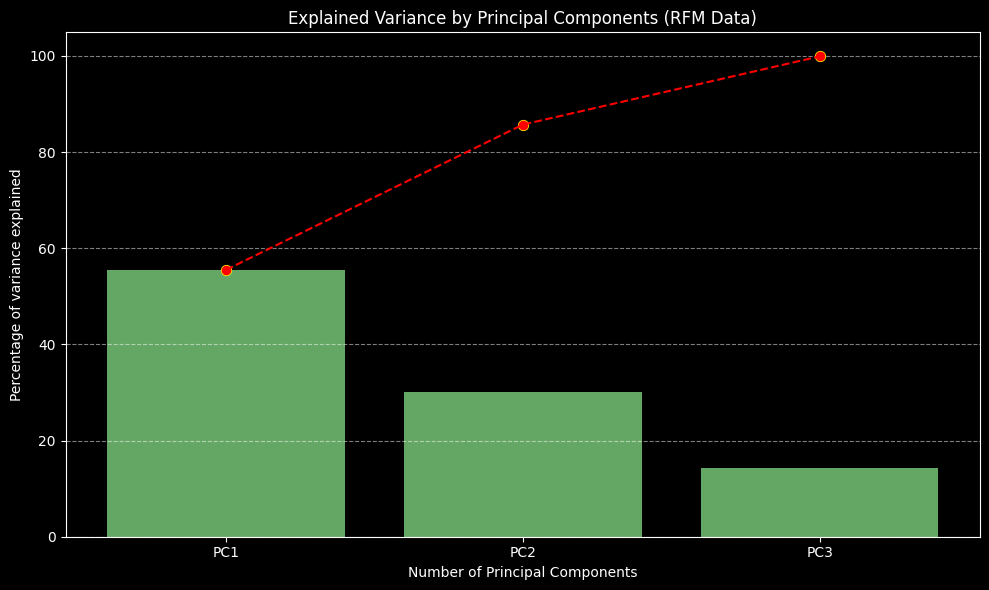

In [ ]:
# Create a PCA object for the RFM data
pca_rfm = PCA()
# Fit PCA to our scaled RFM features
pca_rfm.fit(rfm_scaled_df)
# Get PCA coordinates
pca_rfm_data = pca_rfm.transform(rfm_scaled_df)

# Calculate explained variance ratio
per_var_rfm = np.round(pca_rfm.explained_variance_ratio_ * 100, decimals=1)
labels_all_rfm = ['PC' + str(x) for x in range(1, len(per_var_rfm) + 1)]

# Limit to the first 3 components for display, as RFM is only 3 features
per_var_rfm_display = per_var_rfm[:3]
labels_rfm_display = labels_all_rfm[:3]

# Create an explained variance plot for RFM
with plt.style.context('dark_background'):
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Percentage of variance explained")
    plt.bar(range(1, len(per_var_rfm_display) + 1), per_var_rfm_display,
            tick_label=labels_rfm_display, color="lightgreen", alpha=0.7)
    plt.plot(range(1, len(per_var_rfm_display) + 1), np.cumsum(per_var_rfm_display),
             color="red", marker='o', linestyle='--')
    plt.scatter(range(1, len(per_var_rfm_display) + 1), np.cumsum(per_var_rfm_display),
                color="yellow", s=50)
    plt.title("Explained Variance by Principal Components (RFM Data)")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

**Observation:** With only three features (R, F, M), PCA is straightforward. The first PC typically explains a large portion, but all three components are often needed to capture most of the variance.

Now, let's visualize the customers in the 2D PCA space, coloring them by Country to see if geographic location plays a role in customer behavior patterns. We'll focus on the top 10 countries by customer count to keep the legend manageable, and group others as 'Other'.

In [ ]:
# Prepare data for plotting
pca_rfm_df = pd.DataFrame(data=pca_rfm_data[:, 0:2], columns=['PC1', 'PC2'])
pca_rfm_df['CustomerID'] = rfm_df['CustomerID'] # Keep CustomerID for merging

# Merge with Country information
customer_country_data = rfm_df[['CustomerID', 'Country']]
pca_rfm_df = pd.merge(pca_rfm_df, customer_country_data, on='CustomerID', how='left')

# Get top 10 countries and label others as 'Other'
top_countries = pca_rfm_df['Country'].value_counts().nlargest(10).index
pca_rfm_df['Country_Grouped'] = pca_rfm_df['Country'].apply(lambda x: x if x in top_countries else 'Other')

# Plot using Plotly Express
fig = px.scatter(pca_rfm_df, x='PC1', y='PC2', color='Country_Grouped',
                 title="Customer Segmentation via PCA (RFM - Colored by Country)",
                 labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
                 hover_data=['CustomerID', 'Country_Grouped', 'PC1', 'PC2'],
                 height=700, width=1000,
                 color_discrete_sequence=px.colors.qualitative.Alphabet) # Use a good color sequence
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font_color='white'
)
fig.show(renderer="colab")

The next natural step is to apply t-SNE and then UMAP to the real RFM data.

This will allow us to compare how these non-linear methods perform in revealing customer segments compared to PCA, especially with real-world complexities.

Let's continue with t-SNE:

# 4. Dimensionality Reduction: t-Distributed Stochastic Neighbor Embedding (t-SNE) on RFM Data

As we saw with the synthetic data, t-SNE excels at uncovering non-linear relationships and local clusters within the data. With our real RFM features, t-SNE should provide a more nuanced view of customer segments compared to the linear PCA.

We'll use the same perplexity and n_iter parameters as a starting point, but remember that experimenting with these values is key to finding the most insightful visualization for your specific dataset.

In [ ]:
# Set parameters for t-SNE
random_state = 42
n_components = 2  # We want 2D for visualization
perplexity = 30   # Experiment with values like 5, 15, 50, 100
n_iter = 1000     # Number of iterations for optimization

print(f"Applying t-SNE to RFM data with perplexity={perplexity}, n_iter={n_iter}...")

# Create a t-SNE model object
model_tsne_rfm = TSNE(n_components=n_components, random_state=random_state,
                      perplexity=perplexity, n_iter=n_iter, n_jobs=-1, verbose=1)

# Fit and transform the scaled RFM data
tsne_rfm_data = model_tsne_rfm.fit_transform(rfm_scaled_df)

print("t-SNE on RFM data completed.")

# Create a DataFrame for t-SNE results
tsne_rfm_df = pd.DataFrame(data=tsne_rfm_data, columns=['TSNE1', 'TSNE2'])
tsne_rfm_df['CustomerID'] = rfm_df['CustomerID'] # Keep CustomerID for merging

# Merge with Country information for coloring
tsne_rfm_df = pd.merge(tsne_rfm_df, customer_country_data, on='CustomerID', how='left')

# Get top 10 countries and label others as 'Other' (consistent with PCA plot)
tsne_rfm_df['Country_Grouped'] = tsne_rfm_df['Country'].apply(lambda x: x if x in top_countries else 'Other')

# Plot using Plotly Express
fig = px.scatter(tsne_rfm_df, x='TSNE1', y='TSNE2', color='Country_Grouped',
                 title=f"Customer Segmentation via t-SNE (RFM - Perplexity={perplexity})",
                 labels={'TSNE1': 't-SNE Component 1', 'TSNE2': 't-SNE Component 2'},
                 hover_data=['CustomerID', 'Country_Grouped', 'TSNE1', 'TSNE2'],
                 height=700, width=1000,
                 color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font_color='white'
)
fig.show(renderer="colab")

Applying t-SNE to RFM data with perplexity=30, n_iter=1000...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4338 samples in 0.007s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] Computed neighbors for 4338 samples in 0.263s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4338
[t-SNE] Computed conditional probabilities for sample 2000 / 4338
[t-SNE] Computed conditional probabilities for sample 3000 / 4338
[t-SNE] Computed conditional probabilities for sample 4000 / 4338
[t-SNE] Computed conditional probabilities for sample 4338 / 4338
[t-SNE] Mean sigma: 0.035184
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.517166
[t-SNE] KL divergence after 1000 iterations: 0.483726
t-SNE on RFM data completed.


**Observations from t-SNE Plot on RFM Data:**
* How do the clusters here compare to the PCA plot? Is the separation generally better defined?
* Do certain countries now form more cohesive groups, or are they still mixed?
* Can you visually identify distinct customer behavior segments (e.g., a tight cluster of high-frequency buyers vs. a dispersed group of infrequent purchasers)?

**Experimentation Challenge (Important!):**

Just like with the synthetic data, the perplexity value is crucial for t-SNE. Re-run the t-SNE code cell with different perplexity values (e.g., 5, 15, 50, 100, 200). Observe how the clustering changes. Which perplexity value do you think gives the most meaningful and stable representation of customer segments in this real dataset? Why?

In [ ]:
for x in [1, 10, 25, 50, 60, 100]:
  random_state = 42
  n_components = 2  #
  perplexity = x
  n_iter = 1000

  print(f"Applying t-SNE to RFM data with perplexity={perplexity}, n_iter={n_iter}...")


  model_tsne_rfm = TSNE(n_components=n_components, random_state=random_state,
                      perplexity=perplexity, n_iter=n_iter, n_jobs=-1, verbose=1)


  tsne_rfm_data = model_tsne_rfm.fit_transform(rfm_scaled_df)

  print("t-SNE on RFM data completed.")


  tsne_rfm_df = pd.DataFrame(data=tsne_rfm_data, columns=['TSNE1', 'TSNE2'])
  tsne_rfm_df['CustomerID'] = rfm_df['CustomerID'] # Keep CustomerID for merging


  tsne_rfm_df = pd.merge(tsne_rfm_df, customer_country_data, on='CustomerID', how='left')


  tsne_rfm_df['Country_Grouped'] = tsne_rfm_df['Country'].apply(lambda x: x if x in top_countries else 'Other')


  fig = px.scatter(tsne_rfm_df, x='TSNE1', y='TSNE2', color='Country_Grouped',
                  title=f"Customer Segmentation via t-SNE (RFM - Perplexity={perplexity})",
                  labels={'TSNE1': 't-SNE Component 1', 'TSNE2': 't-SNE Component 2'},
                  hover_data=['CustomerID', 'Country_Grouped', 'TSNE1', 'TSNE2'],
                  height=700, width=1000,
                  color_discrete_sequence=px.colors.qualitative.Alphabet)
  fig.update_layout(
      plot_bgcolor='rgba(0,0,0,0)',
      paper_bgcolor='rgba(0,0,0,0)',
      font_color='white'
  )
  fig.show(renderer="colab")

Applying t-SNE to RFM data with perplexity=1, n_iter=1000...
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 4338 samples in 0.007s...
[t-SNE] Computed neighbors for 4338 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4338
[t-SNE] Computed conditional probabilities for sample 2000 / 4338
[t-SNE] Computed conditional probabilities for sample 3000 / 4338
[t-SNE] Computed conditional probabilities for sample 4000 / 4338
[t-SNE] Computed conditional probabilities for sample 4338 / 4338
[t-SNE] Mean sigma: 0.000423


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.770744
[t-SNE] KL divergence after 1000 iterations: 1.320036
t-SNE on RFM data completed.


Applying t-SNE to RFM data with perplexity=10, n_iter=1000...
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 4338 samples in 0.004s...
[t-SNE] Computed neighbors for 4338 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4338
[t-SNE] Computed conditional probabilities for sample 2000 / 4338
[t-SNE] Computed conditional probabilities for sample 3000 / 4338
[t-SNE] Computed conditional probabilities for sample 4000 / 4338
[t-SNE] Computed conditional probabilities for sample 4338 / 4338
[t-SNE] Mean sigma: 0.017183


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.980652
[t-SNE] KL divergence after 1000 iterations: 0.603330
t-SNE on RFM data completed.


Applying t-SNE to RFM data with perplexity=25, n_iter=1000...
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 4338 samples in 0.004s...
[t-SNE] Computed neighbors for 4338 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4338
[t-SNE] Computed conditional probabilities for sample 2000 / 4338
[t-SNE] Computed conditional probabilities for sample 3000 / 4338
[t-SNE] Computed conditional probabilities for sample 4000 / 4338
[t-SNE] Computed conditional probabilities for sample 4338 / 4338
[t-SNE] Mean sigma: 0.031142


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.537056
[t-SNE] KL divergence after 1000 iterations: 0.499914
t-SNE on RFM data completed.


Applying t-SNE to RFM data with perplexity=50, n_iter=1000...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 4338 samples in 0.005s...
[t-SNE] Computed neighbors for 4338 samples in 0.183s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] Computed conditional probabilities for sample 1000 / 4338
[t-SNE] Computed conditional probabilities for sample 2000 / 4338
[t-SNE] Computed conditional probabilities for sample 3000 / 4338
[t-SNE] Computed conditional probabilities for sample 4000 / 4338
[t-SNE] Computed conditional probabilities for sample 4338 / 4338
[t-SNE] Mean sigma: 0.049796
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.297974
[t-SNE] KL divergence after 1000 iterations: 0.443945
t-SNE on RFM data completed.


Applying t-SNE to RFM data with perplexity=60, n_iter=1000...
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 4338 samples in 0.005s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] Computed neighbors for 4338 samples in 0.230s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4338
[t-SNE] Computed conditional probabilities for sample 2000 / 4338
[t-SNE] Computed conditional probabilities for sample 3000 / 4338
[t-SNE] Computed conditional probabilities for sample 4000 / 4338
[t-SNE] Computed conditional probabilities for sample 4338 / 4338
[t-SNE] Mean sigma: 0.056360
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.450138
[t-SNE] KL divergence after 1000 iterations: 0.433542
t-SNE on RFM data completed.


Applying t-SNE to RFM data with perplexity=100, n_iter=1000...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 4338 samples in 0.005s...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] Computed neighbors for 4338 samples in 0.337s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4338
[t-SNE] Computed conditional probabilities for sample 2000 / 4338
[t-SNE] Computed conditional probabilities for sample 3000 / 4338
[t-SNE] Computed conditional probabilities for sample 4000 / 4338
[t-SNE] Computed conditional probabilities for sample 4338 / 4338
[t-SNE] Mean sigma: 0.079030
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.700691
[t-SNE] KL divergence after 1000 iterations: 0.401719
t-SNE on RFM data completed.


**Answers**

1. Yes, the separation of clusters in the t-SNE plot is generally much better defined and more distinct compared to the PCA plot. PCA is a linear reduction tool and hence would not be able to give us the kind of depth we get with t-SNE.

2. While the t-SNE plot shows some areas where customers from the same country tend to cluster together (e.g., there are denser pockets of 'Germany' or 'France' customers), mainly, customers from the 'United Kingdom' (which is the largest group) remain very dispersed. This suggests that while geographic location might influence some purchasing behaviors, the metrics are not country specific. Customers from the UK, being the majority, exhibit a wider range of behaviors, hence they are present in multiple clusters. Similarly, it is possible that if the other countries were better represented, they would show similar dispersion.

3. Yes, visually, the t-SNE plot makes it much easier to identify distinct customer behavior segments based on the given characteristics. We can infer that:




    Tight, dense clusters likely represent groups of customers with very similar  profiles. For example, a cluster at one extreme could be highly repetitive, high-value, recent purchasers.
    Smaller groups might indicate more niche segments, customers with less typical behavior, or outliers. A group on the opposite extreme could represent customers who haven't purchased recently, infrequently, and cheaper goods.

# 5. Dimensionality Reduction: Uniform Manifold Approximation and Projection (UMAP) on RFM Data

Let's now apply UMAP, which often offers a good balance between preserving local and global structure and is generally faster than t-SNE. We'll continue to color by Country_Grouped.

In [ ]:
# # Uncomment the line below if you haven't installed umap-learn
!pip install -q umap-learn

import umap  # Make sure this is imported if you uncommented it at the top

#Set parameters for UMAP
random_state = 42
n_components = 2
n_neighbors = 15  # Controls how UMAP balances local vs. global structure. Higher value = more global.
min_dist = 0.1    # Controls how tightly the points are packed together. Lower value = tighter clusters.

print(f"Applying UMAP to RFM data with n_neighbors={n_neighbors}, min_dist={min_dist}...")

# # Create a UMAP model object
model_umap_rfm = umap.UMAP(n_components=n_components, random_state=random_state,
                        n_neighbors=n_neighbors, min_dist=min_dist, verbose=True)

# # Fit and transform the scaled RFM data
umap_rfm_data = model_umap_rfm.fit_transform(rfm_scaled_df)

print("UMAP on RFM data completed.")

# # Create a DataFrame for UMAP results
umap_rfm_df = pd.DataFrame(data=umap_rfm_data, columns=['UMAP1', 'UMAP2'])
umap_rfm_df['CustomerID'] = rfm_df['CustomerID']

# # Merge with Country information for coloring
umap_rfm_df = pd.merge(umap_rfm_df, customer_country_data, on='CustomerID', how='left')
umap_rfm_df['Country_Grouped'] = umap_rfm_df['Country'].apply(lambda x: x if x in top_countries else 'Other')

# # Plot using Plotly Express
fig = px.scatter(umap_rfm_df, x='UMAP1', y='UMAP2', color='Country_Grouped',
                  title=f"Customer Segmentation via UMAP (RFM - n_neighbors={n_neighbors}, min_dist={min_dist})",
                  labels={'UMAP1': 'UMAP Component 1', 'UMAP2': 'UMAP Component 2'},
                  hover_data=['CustomerID', 'Country_Grouped', 'UMAP1', 'UMAP2'],
                  height=700, width=1000,
                  color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font_color='white'
)
fig.show(renderer="colab")


Applying UMAP to RFM data with n_neighbors=15, min_dist=0.1...
UMAP(n_jobs=1, random_state=42, verbose=True)
Sun Nov 23 11:46:54 2025 Construct fuzzy simplicial set
Sun Nov 23 11:46:54 2025 Finding Nearest Neighbors
Sun Nov 23 11:46:54 2025 Building RP forest with 8 trees


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Sun Nov 23 11:47:00 2025 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	Stopping threshold met -- exiting after 2 iterations
Sun Nov 23 11:47:20 2025 Finished Nearest Neighbor Search
Sun Nov 23 11:47:21 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Nov 23 11:47:30 2025 Finished embedding
UMAP on RFM data completed.


**UMAP Observations on RFM Data:**
* In case you have uncommented and run UMAP, how does UMAP's representation of the clusters compare to both PCA and t-SNE? Does it show a clearer global structure or sharper local clusters?
* Are there any "bridges" or connections between clusters that UMAP highlights better than t-SNE?
* Consider how different n_neighbors (e.g., 5, 50, 100) and min_dist (e.g., 0.0, 0.5) values might alter the UMAP embedding.

1. Yes, UMAP's representation of the clusters is better than both PCA and t-SNE's. It performs better globally as well as locally, and is quicker too.

2. Yes, UMAP is able to show links between clusters. This is because t-SNE is a local model, it prioritizes the neighbours. However, UMAP is both local and global, hence it can help is see the links between both as well.

# 6. Comprehensive Interpretation and Business Implications (Real Data)
Now that you've visualized the real customer data using three different dimensionality reduction techniques, it's time to consolidate your observations and think about their practical business value.

**Key Questions for Interpretation:**
1. **General Cluster Shapes and Density:** Do you observe distinct, well-separated clusters, or more amorphous blobs? What does the density of points within a cluster suggest about the commonality of that customer behavior?
2. **RFM Behavior within Clusters:** While we don't have direct labels for "High-Value" or "Churn-Risk" yet, you can infer them. For example:
   * A cluster positioned far to the right on an axis related to Monetary value would likely be high-spenders.
   * A cluster with high Recency (meaning they haven't bought recently) would be candidates for re-engagement.
   * You could even go back to the original rfm_df and calculate the average R, F, M for customers within visually identified clusters (e.g., by selecting points in Plotly or by applying k-means after visualization).
3. **Geographical Influence:** How does the Country_Grouped coloring help or hinder your interpretation? Do customers from the same country tend to cluster together, suggesting regional buying habits, or are they spread across various behavioral segments?
4. **Comparison of Techniques:** Which visualization technique (PCA, t-SNE, UMAP) provided the most insightful or interpretable view for this real dataset? Why do you think that is? (Consider linearity, preservation of local/global structure).
5. **Actionable Business Strategies:** Based on the observed segments, what concrete recommendations could you make to the e-commerce company?
   * **High-Value Customers:** How would you nurture them?
   * **New/Infrequent Customers:** How would you encourage more purchases?
   * **Churn-Risk Customers:** What strategies could prevent them from leaving?
   * **Geographic-Specific Insights:** Are there opportunities for localized marketing or product offerings?



This real-world exercise demonstrates that while data preprocessing and feature engineering require more effort, the insights gained can be directly translated into tangible business strategies. Visualizing your data is often the crucial first step in understanding complex patterns and driving informed decision-making.

**Answers**

1. With each data visualization pattern, the clusters seem to get more distinct and we are able to demaracate easily. In this way, I would say PCA < t-SNE < UMAP in terms of visualization.

3. The Country_Grouped coloring was helpful in highlighting the distribution of customers across different regions. It allowed for a quick visual assessment. While the plots (especially t-SNE and UMAP) showed some areas where customers from certain countries might tend to collect more (e.g., small pockets of 'Germany' or 'France' customers), the overarching trend is that customers from the same country are largely spread across various behavioral segments.

    The 'United Kingdom' (being the largest group by far) was particularly dispersed across all clusters in every visualization. This indicates that UK customers exhibit a wide rang of purchasing behaviors, not confined to a single segment. Their large number also means they often populate multiple distinct behavioral groups, making it harder to discern a 'UK-specific' cluster.

4. With each data visualization pattern, the clusters seem to get more distinct and we are able to demaracate easily. In this way, I would say PCA < t-SNE < UMAP in terms of visualization.


    PCA (Principal Component Analysis):
    
    Linearity and Global Structure: PCA is a linear dimensionality reduction technique. It focuses on keeping the global variance in the data, essentially projecting the data onto new axes that capture the maximum spread. While useful for understanding the primary directions of variation, it cannot uncover complex, non-linear relationships that are often present in real-world customer behavior data. Hence, it performs worse on the RFM plot.

    t-SNE (t-Distributed Stochastic Neighbor Embedding):

    Non-linearity and Local Structure: t-SNE is a non-linear technique excellent at preserving local neighborhoods. Therfore, points in the higher dimensions which are close remain close in lower dimensions too. This makes it  effective at revealing distinct clusters.
    Its plots were much more informative than PCA's due to the same reason; they were able to keep local differences the same

    UMAP (Uniform Manifold Approximation and Projection):
    Non-linearity, Local, and Global Structure: UMAP is also a non-linear technique, but it offers a balance between preserving both local and global data structure compared to t-SNE. It aims to represent the shape of data in lower dimensions. It's also faster to compute and often less sensitive to parameter choices than t-SNE. It gave us the best usage in RFM data.

5. For High-value customers: Loyalty programs (more discount the more you shop, or a 'points' system the more you shop) might keep them coming.

    For New-customers: Discounts on welcome; maybe on first 3 or 5 shops. They can then be slowly transitioned to loyalty programs. Using a few targeted products can also help beat the competition.

    For churn-risk customers: feedback forms to understand why they feel so, and how we can solve their dissatisfaction if needed.

    Geographic specific: I don't think we get much geographic information from this. The customers seem widely spread and not very related to each other. Localized products, and campaigns, bringing their home roots might help here.


**So I now hope you appreciate the valuable insights visualization techniques provide us with.**

Best of luck for the next Module!